# **Import Library**

In [40]:
!pip freeze > requirements.txt
!pip install tensorflowjs
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from skimage.util import img_as_ubyte
from skimage.filters import gaussian
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import tensorflowjs as tfjs
from tensorflow.lite.python.interpreter import Interpreter

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
print(tf.__version__)

2.18.0


# **Data Loading**

## **Mengambil Data dari Kaggle**

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sagitasantia","key":"9e08ae51ce19db90924d581320eddc72"}'}

In [5]:
!kaggle datasets download -d mibrahimhanif/jenis-kucing
!unzip jenis-kucing.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: train val/Belang Tiga/a9fa38e17a4ed0084f20fb7065133600_0_820.jpeg  
  inflating: train val/Belang Tiga/a9fa38e17a4ed0084f20fb7065133600_0_9573.jpeg  
  inflating: train val/Belang Tiga/aa2ce8aaa83640e62cdb244b9ad79d7f_0_3001.jpeg  
  inflating: train val/Belang Tiga/aa2ce8aaa83640e62cdb244b9ad79d7f_0_5822.jpeg  
  inflating: train val/Belang Tiga/aa2ce8aaa83640e62cdb244b9ad79d7f_0_7110.jpeg  
  inflating: train val/Belang Tiga/aa2ce8aaa83640e62cdb244b9ad79d7f_0_7417.jpeg  
  inflating: train val/Belang Tiga/aa2ce8aaa83640e62cdb244b9ad79d7f_0_7982.jpeg  
  inflating: train val/Belang Tiga/aa75dc5c22a4f533baa6f8f6da1dfcc8_0_4289.jpeg  
  inflating: train val/Belang Tiga/aa75dc5c22a4f533baa6f8f6da1dfcc8_0_4874.jpeg  
  inflating: train val/Belang Tiga/aa75dc5c22a4f533baa6f8f6da1dfcc8_0_8105.jpeg  
  inflating: train val/Belang Tiga/aa75dc5c22a4f533baa6f8f6da1dfcc8_0_8827.jpeg  
  inflating: train val/Belang Tiga/aa75d

# **Data Preparation**

In [6]:
# Direktori awal untuk train dan test
train_dir = "jenis-kucing/train val"
test_dir = "jenis-kucing/test"
# Direktori baru untuk dataset gabungan
combined_dir = "jenis-kucing/dataset"


In [7]:
os.makedirs(combined_dir, exist_ok=True)

In [8]:
import zipfile
import os

zip_path = 'jenis-kucing.zip'
extract_dir = 'jenis-kucing'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"File zip telah diekstrak ke {extract_dir}")


File zip telah diekstrak ke jenis-kucing


In [9]:
if not os.path.exists(train_dir):
    print(f"Direktori {train_dir} tidak ada!")
else:
    for category in os.listdir(train_dir):
        category_dir = os.path.join(train_dir, category)
        if os.path.isdir(category_dir):
            shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)
            print(f"Menyalin {category_dir} ke {combined_dir}")


if not os.path.exists(test_dir):
    print(f"Direktori {test_dir} tidak ada!")
else:
    for category in os.listdir(test_dir):
        category_dir = os.path.join(test_dir, category)
        if os.path.isdir(category_dir):
            shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)
            print(f"Menyalin {category_dir} ke {combined_dir}")

Menyalin jenis-kucing/train val/Hitam ke jenis-kucing/dataset
Menyalin jenis-kucing/train val/Belang Tiga ke jenis-kucing/dataset
Menyalin jenis-kucing/train val/Kampung ke jenis-kucing/dataset


# **Dataset Checking**

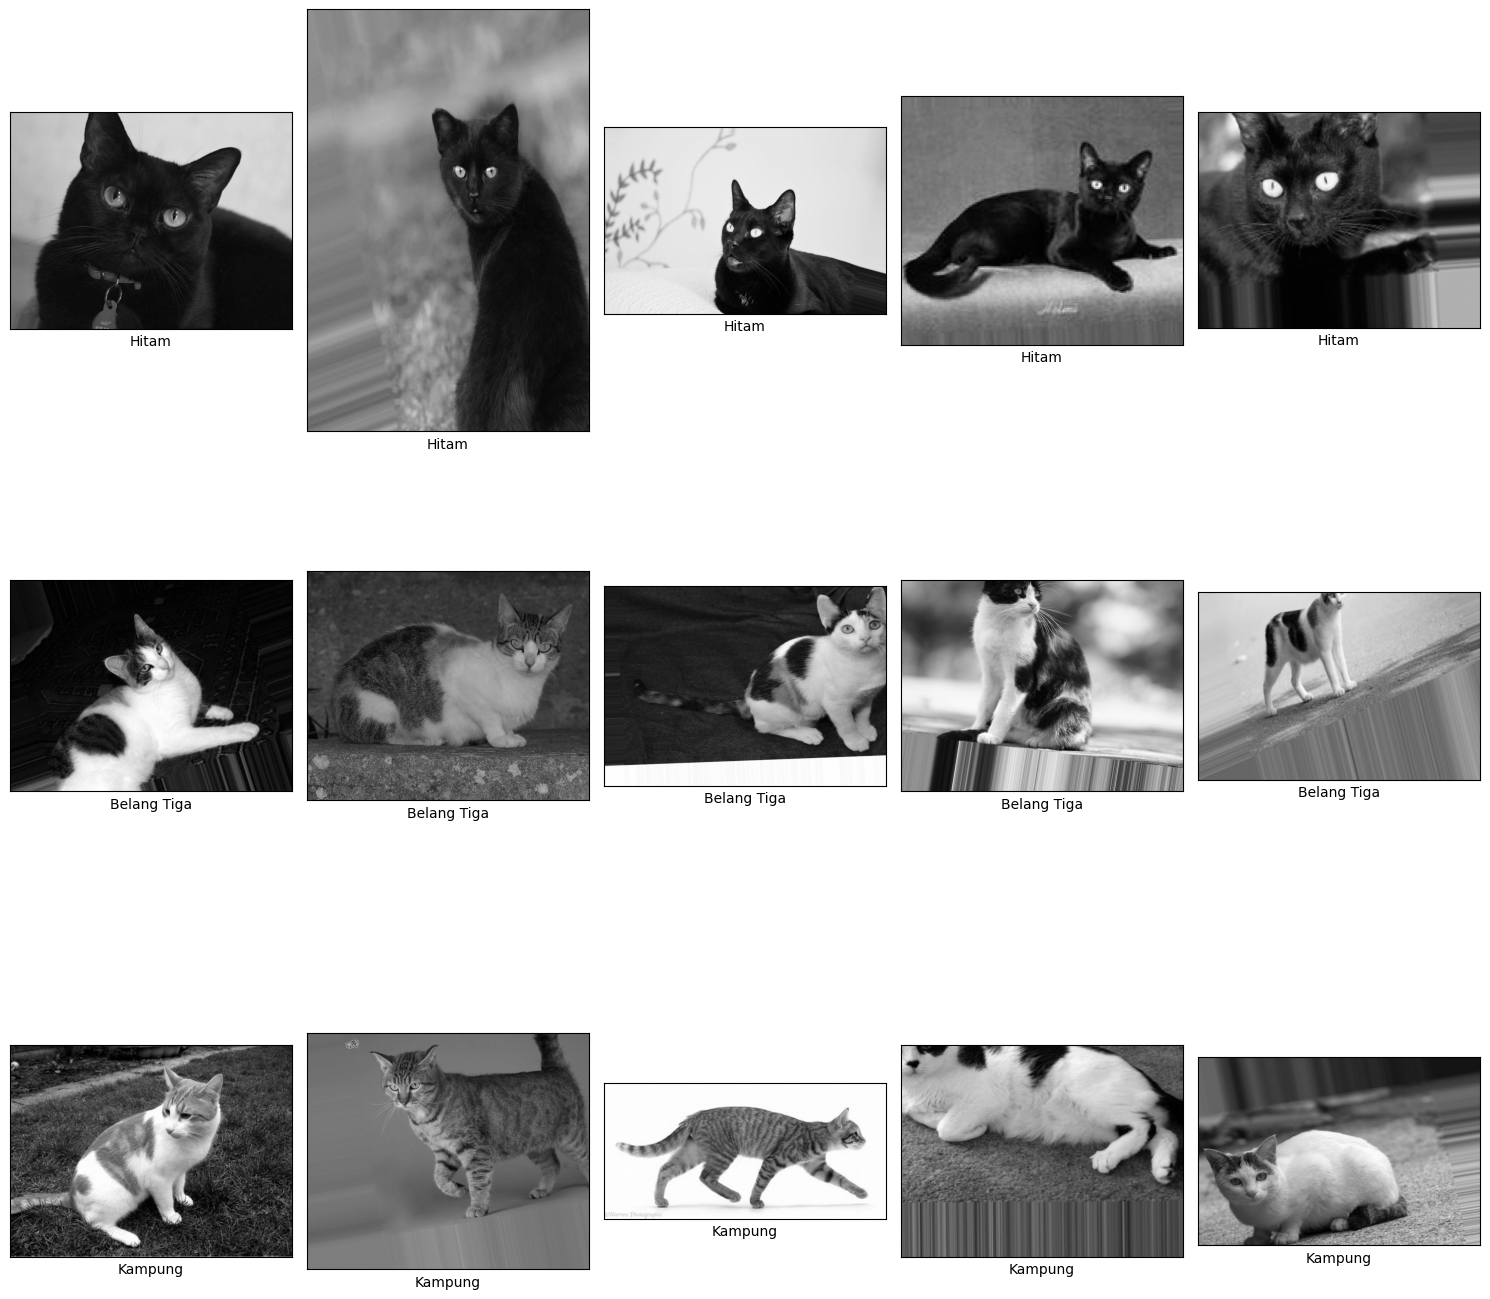

In [10]:
cat_image = {}

path = "jenis-kucing/dataset/"
for i in os.listdir(path):
    cat_image[i] = os.listdir(os.path.join(path, i))


fig, axs = plt.subplots(len(cat_image.keys()), 5, figsize=(15, 15))
for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(cat_image[class_name], 5, replace=False)
    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        try:
            img = Image.open(img_path).convert("L")
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
fig.tight_layout()
plt.show()


# **Plot Distribusi**

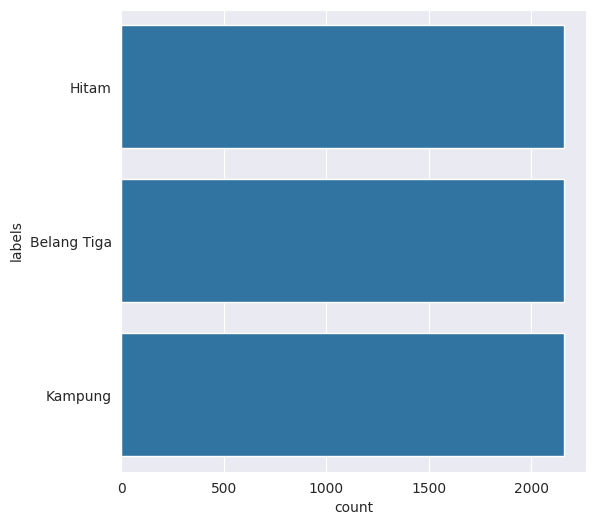

In [11]:
lung_path = "jenis-kucing/dataset/"
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

Label = distribution_train['labels']
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)
plt.show()


# **Data Augmentation**

In [12]:
# Fungsi augmentasi gambar
def anticlockwise_rotation(img):
    return rotate(img, angle=90, resize=True)

def clockwise_rotation(img):
    return rotate(img, angle=-90, resize=True)

def flip_up_down(img):
    return np.flipud(img)

def add_brightness(img, factor=1.5):
    img = np.array(img, dtype=np.float32)
    img = img * factor
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def blur_image(img):
    return gaussian(img, sigma=1)

def sheared(img):
    transform = AffineTransform(shear=0.5)
    return warp(img, transform)

def warp_shift(img):
    transform = AffineTransform(translation=(30, 0))
    return warp(img, transform)

# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "jenis-kucing/dataset"
augmented_path = "jenis-kucing/augmented_data"
images = []


for label_folder in os.listdir(images_path):
    label_path = os.path.join(images_path, label_folder)
    if os.path.isdir(label_path):
        for filename in os.listdir(label_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                images.append(os.path.join(label_path, filename))

images_to_generate = 2000
i = 1

os.makedirs(augmented_path, exist_ok=True)

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image = None
        n = 0
        transformation_count = random.randint(1, len(transformations))

        while n < transformation_count:
            key = random.choice(list(transformations))
            transformed_image = transformations[key](original_image)
            n = n + 1

        label_folder = image.split('/')[-2]
        new_image_path = f"{augmented_path}/{label_folder}/augmented_image_{i}.jpg"
        os.makedirs(os.path.dirname(new_image_path), exist_ok=True)
        transformed_image = img_as_ubyte(transformed_image)
        cv2.imwrite(new_image_path, transformed_image)
        i = i + 1
    except Exception as e:
        print(f'Could not read the image {image}: {e}, hence skipping it.')

print("Augmentasi selesai!")


Augmentasi selesai!


# **Data Splitting**

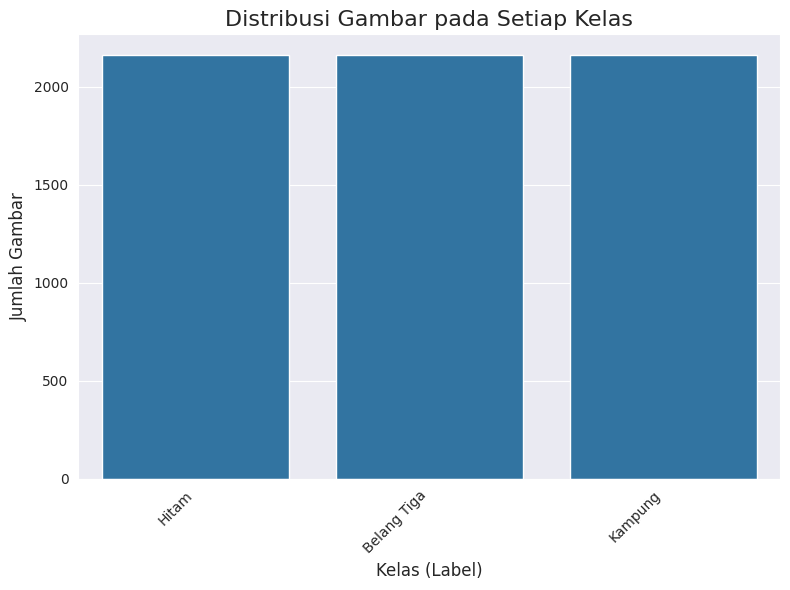

In [13]:
lung_path = "jenis-kucing/dataset/"
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

Label = distribution_train['labels']
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x=Label)


plt.title('Distribusi Gambar pada Setiap Kelas', fontsize=16)
plt.xlabel('Kelas (Label)', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [14]:
X = distribution_train['path']
y = distribution_train['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)  # 80% data untuk pelatihan, 20% untuk pengujian

In [15]:
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [16]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')


df_all.sample(5)
datasource_path = "jenis-kucing/dataset/"
dataset_path = "Dataset-Final/"


set    labels     
test   Belang Tiga     431
       Hitam           444
       Kampung         421
train  Belang Tiga    1729
       Hitam          1716
       Kampung        1739
dtype: int64 




In [17]:
for index, row in df_all.iterrows():
    file_path = row['path']
    if os.path.exists(file_path) == False:
        file_path = os.path.join(datasource_path, row['labels'], row['file_name'])
    if os.path.exists(os.path.join(dataset_path, row['set'], row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path, row['set'], row['labels']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path, row['set'], row['labels'], destination_file_name)


    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path, file_dest)


# **Image Data Generator**

In [18]:
# Definisikan direktori training dan test berdasarkan dataset yang telah dipisah
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

# Definisikan subfolder untuk setiap kategori label
train_belang_tiga = os.path.join(TRAIN_DIR, 'Belang Tiga')
train_hitam = os.path.join(TRAIN_DIR, 'Hitam')
train_kampung = os.path.join(TRAIN_DIR, 'Kampung')

test_belang_tiga = os.path.join(TEST_DIR, 'Belang Tiga')
test_hitam = os.path.join(TEST_DIR, 'Hitam')
test_kampung = os.path.join(TEST_DIR, 'Kampung')


print("Total number of Belang Tiga images in training set: ", len(os.listdir(train_belang_tiga)))
print("Total number of Hitam images in training set: ", len(os.listdir(train_hitam)))
print("Total number of Kampung images in training set: ", len(os.listdir(train_kampung)))

print("Total number of Belang Tiga images in test set: ", len(os.listdir(test_belang_tiga)))
print("Total number of Hitam images in test set: ", len(os.listdir(test_hitam)))
print("Total number of Kampung images in test set: ", len(os.listdir(test_kampung)))


Total number of Belang Tiga images in training set:  1729
Total number of Hitam images in training set:  1716
Total number of Kampung images in training set:  1739
Total number of Belang Tiga images in test set:  431
Total number of Hitam images in test set:  444
Total number of Kampung images in test set:  421


In [19]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Menyiapkan generator untuk data pelatihan
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Menyiapkan generator untuk data validasi
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Menyiapkan generator untuk data pengujian
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)


Found 4149 images belonging to 3 classes.
Found 1035 images belonging to 3 classes.
Found 1296 images belonging to 3 classes.


# **Pembangunan Model dengan Beberapa Skema Parameter Tuning**

## **Skema CNN Architecture dengan 32 Neurons pada Conv Layer**

In [20]:
# Inisialisasi model Sequential
model_1 = Sequential()
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())

# 1st Dense Layer
model_1.add(Dense(128, activation='relu'))

# 1st Dropout Layer
model_1.add(Dropout(0.5))

# 2nd Dense Layer
model_1.add(Dense(64, activation='relu'))

# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer
model_1.add(Dense(3, activation='softmax'))

# Compile Model
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Ringkasan Arsitektur Model
print(model_1.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,403,587 (5.35 MB)

 Trainable params: 1,403,395 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [21]:
# Path untuk direktori training (untuk setiap kelas)
train_belang_tiga = os.path.join(TRAIN_DIR, 'Belang Tiga')
train_hitam = os.path.join(TRAIN_DIR, 'Hitam')
train_kampung = os.path.join(TRAIN_DIR, 'Kampung')

# Hitung jumlah gambar untuk setiap kelas
count_belang_tiga = len(os.listdir(train_belang_tiga))
count_hitam = len(os.listdir(train_hitam))
count_kampung = len(os.listdir(train_kampung))

# Hitung class weights untuk setiap kelas
total_samples = count_belang_tiga + count_hitam + count_kampung
weight_belang_tiga = (1 / count_belang_tiga) * (total_samples / 3.0)
weight_hitam = (1 / count_hitam) * (total_samples / 3.0)
weight_kampung = (1 / count_kampung) * (total_samples / 3.0)
class_weights = {0: weight_belang_tiga, 1: weight_hitam, 2: weight_kampung}

# Melatih model
history_1 = model_1.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.5537 - loss: 2.1779 - val_accuracy: 0.3353 - val_loss: 2.3550
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.6298 - loss: 0.8412 - val_accuracy: 0.3266 - val_loss: 3.2749
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 332s 3s/step - accuracy: 0.6297 - loss: 0.7563 - val_accuracy: 0.4928 - val_loss: 1.1402
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.6469 - loss: 0.6806 - val_accuracy: 0.5449 - val_loss: 1.5798
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 331s 3s/step - accuracy: 0.7008 - loss: 0.6089 - val_accuracy: 0.6957 - val_loss: 0.6159
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.7511 - loss: 0.5999 - val_accuracy: 0.6986 - val_loss: 0.6626
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - accuracy: 0.8047 - loss: 0.4722 - val_accuracy: 0.8309 - val_loss: 0.4315
Epoch 8/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.8540 - loss: 0.4083 - val_accu

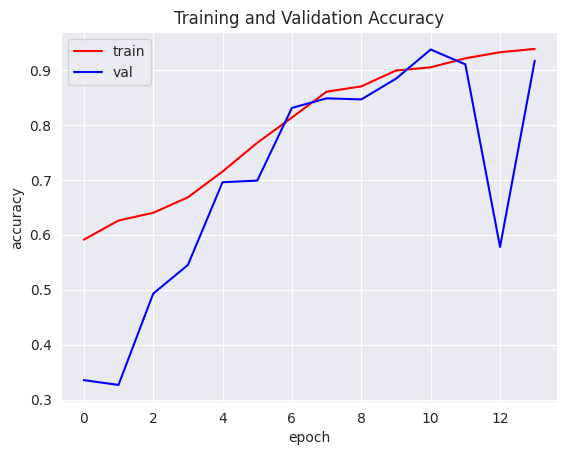

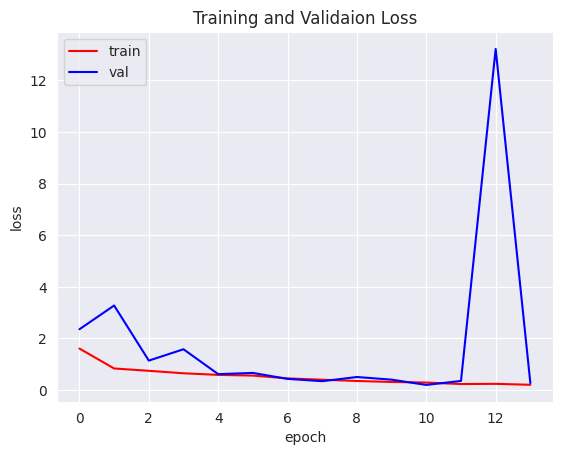

In [24]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

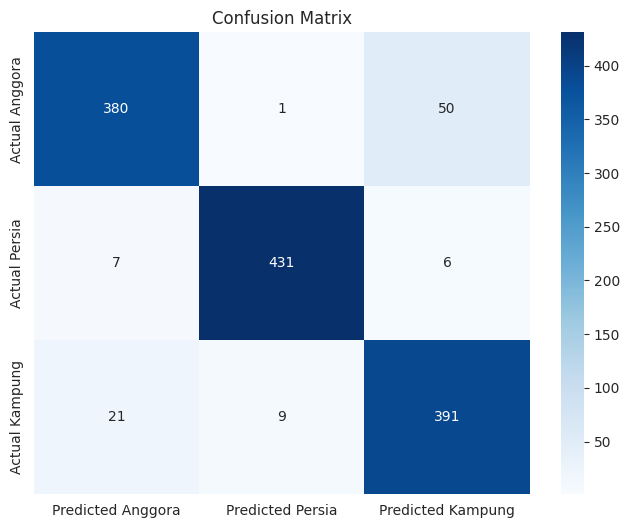


Classification Report:

              precision    recall  f1-score   support

     Anggora     0.9314    0.8817    0.9058       431
      Persia     0.9773    0.9707    0.9740       444
     Kampung     0.8747    0.9287    0.9009       421

    accuracy                         0.9275      1296
   macro avg     0.9278    0.9270    0.9269      1296
weighted avg     0.9287    0.9275    0.9276      1296



In [25]:
test_generator.reset()

# Prediksi pada data test
preds_1 = model_1.predict(test_generator, verbose=0)
preds_1 = preds_1.copy()
preds_1 = np.argmax(preds_1, axis=1)
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1, 2]),
                  index=["Actual Anggora", "Actual Persia", "Actual Kampung"],
                  columns=["Predicted Anggora", "Predicted Persia", "Predicted Kampung"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
print("\nClassification Report:\n")
print(classification_report(y_true=test_generator.classes,
                            y_pred=preds_1,
                            target_names=['Anggora', 'Persia', 'Kampung'],
                            digits=4))


Dari hasil pada **Confusion Matrix** dan **Classification Report**, berikut adalah penjelasan dan interpretasinya:

### **Confusion Matrix**:
- **Baris pertama (Anggora)**:
  - Model memprediksi dengan benar **380** gambar Anggora sebagai Anggora.
  - Ada **1** gambar Anggora yang diprediksi sebagai Persia.
  - Ada **50** gambar Anggora yang diprediksi sebagai Kampung.

- **Baris kedua (Persia)**:
  - Model memprediksi dengan benar **431** gambar Persia sebagai Persia.
  - Ada **7** gambar Persia yang diprediksi sebagai Anggora.
  - Ada **6** gambar Persia yang diprediksi sebagai Kampung.

- **Baris ketiga (Kampung)**:
  - Model memprediksi dengan benar **391** gambar Kampung sebagai Kampung.
  - Ada **21** gambar Kampung yang diprediksi sebagai Anggora.
  - Ada **9** gambar Kampung yang diprediksi sebagai Persia.

### **Classification Report**:
- **Precision**:
  - Untuk **Anggora** adalah 0.9314, artinya dari semua gambar yang diprediksi sebagai Anggora, sekitar **93.14%** adalah benar-benar Anggora.
  - Untuk **Persia** adalah 0.9773, artinya dari semua gambar yang diprediksi sebagai Persia, sekitar **97.73%** adalah benar-benar Persia.
  - Untuk **Kampung** adalah 0.8747, artinya dari semua gambar yang diprediksi sebagai Kampung, sekitar **87.47%** adalah benar-benar Kampung.

- **Recall**:
  - Untuk **Anggora** adalah 0.8817, artinya dari semua gambar Anggora yang sebenarnya, sekitar **88.17%** dapat diprediksi dengan benar.
  - Untuk **Persia** adalah 0.9707, artinya dari semua gambar Persia yang sebenarnya, sekitar **97.07%** dapat diprediksi dengan benar.
  - Untuk **Kampung** adalah 0.9287, artinya dari semua gambar Kampung yang sebenarnya, sekitar **92.87%** dapat diprediksi dengan benar.

- **F1-Score**:
  - F1-score adalah rata-rata harmonis dari precision dan recall, memberikan gambaran yang lebih seimbang antara keduanya.
  - **Anggora**: 0.9058
  - **Persia**: 0.9740
  - **Kampung**: 0.9009

- **Accuracy**:
  - Model memiliki **accuracy** sekitar **92.75%**, artinya sekitar **92.75%** dari seluruh data diuji dapat diprediksi dengan benar.

- **Macro Average**:
  - Ini adalah rata-rata dari precision, recall, dan f1-score di seluruh kelas. Dalam hal ini, nilai-nilainya cukup tinggi, menunjukkan bahwa model bekerja cukup baik di seluruh kelas.

- **Weighted Average**:
  - Ini adalah rata-rata yang memperhitungkan jumlah contoh di setiap kelas. Hal ini juga menunjukkan bahwa model bekerja dengan baik.

### **Kesimpulan**:
Model Anda menunjukkan kinerja yang sangat baik dengan **accuracy** lebih dari 92%. Precision, recall, dan f1-score yang tinggi menunjukkan bahwa model memprediksi dengan benar sebagian besar gambar dari ketiga kelas (Anggora, Persia, dan Kampung).

In [26]:
# Menyimpan model dalam format .h5
model_1.save('submission/saved_model/model_1.h5')

In [27]:
# Mengonversi model Keras ke TensorFlow Lite
model = tf.keras.models.load_model('submission/saved_model/model_1.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TensorFlow Lite ke file
tflite_model_path = 'submission/tflite/model_1.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Menyimpan label (jika diperlukan)
label_path = 'submission/tflite/label1.txt'
with open(label_path, 'w') as f:
    f.write("0: Anggora\n1: Persia\n2: Kampung\n")


Saved artifact at '/tmp/tmpgwsx3uqz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133788974858512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133788974872144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133788998040272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133788998036048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133788974874064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133788998032592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133788998037008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133788998027024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133789040211344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133789040213840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133789040207312

In [30]:
tfjs_model_dir = 'submission/tfjs_model'
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print(f"Model TensorFlow.js disimpan di: {tfjs_model_dir}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


failed to lookup keras version from the file,
    this is likely a weight only file
Model TensorFlow.js disimpan di: submission/tfjs_model


# **Inference**

In [39]:
model_path = 'submission/tflite/model_1.tflite'
# Inisialisasi interpreter TFLite
interpreter = Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Ambil input tensor dan output tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Path ke gambar yang ingin diuji
image_path = 'Dataset-Final/test/Kampung/$_58 - Copy.jpg'
img = image.load_img(image_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

#inference
interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)
class_labels = ['Belang Tiga', 'Hitam', 'Kampung']
print(f"Prediksi kelas: {class_labels[predicted_class]}")


Prediksi kelas: Kampung
